# Figure 2 #

This notebook shows how to extract the transition pathways from the MD trajectory, thereby allowing to understand what is the nature and order of events leading to folding. In particular, we here study the formation of the Watson-Crick base-pairs in the stem and of the Sugar-Watson interaction, characterized by the G9$\chi$ angle in the unusual syn conformation. 

First, we identify transition paths (TP) from folded to unfolded (and vice-versa) as described in "How Fast-Folding Proteins Fold, Science, 2011". In brief, we consider folding/unfolding transitions only when the system transitions fully between unfolded (eRMSD > 1.9) and folded (eRMSD < 0.6) substates. In order to define transition paths, we analyze the trajectory forward in time, and assign folded/unfolded states depending on the last state visited. If, as an example, the trajectory starts from folded (eRMSD < 0.6), all the frames will be considered as folded until the unfolded state (eRMSD > 1.9) is visited.  We then analyze the trajectory backwards in time. Frames that are assigned to one state (e.g., unfolded) in the forward direction and a different state (e.g., folded) in the reverse direction
belong to the transition path connecting the two states.


In [61]:
import pickle
import numpy as np
# read ermsd from pickle
fname = "ermsd.p"
print "# reading pickle %s" % fname,
ermsd = pickle.load(open(fname, "r"))
print " shape ", ermsd.shape
print "####"
# define thresholds for folded and unfolded states, in eRMSD values. 
thr_u = 1.9
thr_f = 0.6

ll = ermsd.shape[0]

# make assignments of folded/unfolded. 
# Initial values are set as -1 (unininitialized).
# If the first/last eRMSD is between the two cutoffs, 
# the state cannot be assigned
forward = -np.ones(ll)
backward = -np.ones(ll)
folded_idx = []
unfolded_idx = []
# loop over the trajectory
for j in range(ll):
    # fill forward. fw is < 0 if eRMSD <thr_f and fw > 1 if eRMSD > thr_u 
    fw = (ermsd[j]-thr_f)/(thr_u-thr_f)
    if(fw>=1):
        forward[j] = 1
        unfolded_idx.append(j)
    elif(fw<=0):
        forward[j] = 0
        folded_idx.append(j)
    else:
        forward[j] = forward[j-1]
        
    # fill backwards
    k = ll-j-1
    bw = (ermsd[k]-thr_f)/(thr_u-thr_f)
    if(bw>=1):
        backward[j] = 1
    elif(bw<=0):
        backward[j] = 0
    else:
        backward[j] = backward[j-1]

# reverse list 
backward = backward[::-1]

# create list of lists with indexes identifying 
# transition paths. 
tps = []
tmp = []
for j in range(ll):
    if(forward[j]+backward[j]==1):
        tmp.append(j)
    else:
        if(len(tmp)!=0):
            tps.append(tmp)            
            tmp = []
if(len(tmp)!=0): tps.append(tmp)
    
# establish whether is folding or unfolding.
# print info and check that the state before/after the TP
# is unfolded or folded. 

for el in tps:
    if(el[0] != 0):
        if(ermsd[el[0]-1] >= thr_u):
            assert(ermsd[el[-1]+1]<= thr_f)
            print "# Folding trajectory: number of frames %d " % len(el)
        if(ermsd[el[0]-1] <= thr_f):
            assert(ermsd[el[-1]+1]>= thr_u)
            print "# Unfolding trajectory: number of frames %d " % len(el)
print "#################"
print "# I have found %d folding/unfolding transitions " % len(tps)


# reading pickle ermsd.p  shape  (20000,)
####
# Unfolding trajectory: number of frames 719 
# Folding trajectory: number of frames 279 
# Unfolding trajectory: number of frames 169 
# Folding trajectory: number of frames 1225 
# Unfolding trajectory: number of frames 164 
# Folding trajectory: number of frames 34 
# Unfolding trajectory: number of frames 294 
# Folding trajectory: number of frames 1069 
#################
# I have found 8 folding/unfolding transitions 


Now we monitor base-pair formation and the $\chi$ angle in G9 during folding and unfolding pathways. We read these information from pickle files. The array *angles* has dimensions *(n,m,7)*, where *n=20000* is the number of frames, *m=14* is the number of nucleotides and the third index runs over the seven torsion angles ($\alpha,\beta,\gamma,\delta,\epsilon,\zeta,\chi$)


In [25]:
# read angles pickle
fname = "angles.p"
print "# reading pickle %s" % fname,
angles,res = pickle.load(open(fname, "r"))
print " - shape", angles.shape

# Read annotation pickle
fname = "pairs.p"
print "# reading pickle %s" % fname, 
pairings,res = pickle.load(open(fname, "r"))
print " - shape ", len(pairings)

# reading pickle angles.p  - shape (20000, 14, 7)
# reading pickle pairs.p  - shape  20000


We now define a function that reads the list of base-pairs. This  function will be used later for plotting, and can be used to count the number of native base-pair interaction, as shown below. 

In [62]:
# this function loops over the indexes and read the annotation relative 
# to base-base interactions in the stem. It returns an array (q,6), 
# where q is the length of the list idxs. 
# The value of the entry is defined as follows:
# 1.0 if the WC base-pair (or SWt) is formed in the stem
# 0.0 if there are no interactions
# -1.0 if there is a non-native base pair
def count_stem(pairs,idxs):
    pairs = {0:13,1:12,2:11,3:10,4:9,5:8}
    wcpairs = np.zeros((len(idxs),6))
    for j,i in enumerate(idxs):
        for p in range(len(pairings[i][0])):
            res1 = pairings[i][0][p][0]
            res2 = pairings[i][0][p][1]
            interaction =  pairings[i][1][p]
            if(res1 not in pairs): continue
            if(res2 != pairs[res1]): continue
            
            if(res1==5):
                # if is 
                if(interaction == "SWt"):
                    wcpairs[j,res1] = 1.0
                else:
                    wcpairs[j,res1] = -1.0
            else:
                if(interaction=="WCc" or interaction == "WWc"):
                    wcpairs[j,res1] = 1.0
                else:
                    wcpairs[j,res1] = -1.0
    return wcpairs

stem_fold = count_stem(pairings,folded_idx)
stem_unfold = count_stem(pairings,unfolded_idx)

# sum elements where stem_fold is 1 to count interactions.
# The last column refers to the SWt interaction, and it is 
# not considered when counting Watson-Crick interactions
number_wc_fold = np.sum(stem_fold[:,:-1]>0,axis=1)
number_wc_unfold = np.sum(stem_unfold[:,:-1]>0,axis=1)

print "Average number of formed WC pairs in folded %4.2f" % np.average(number_wc_fold)
print "Average number of formed WC pairs in unfolded %4.2f" % np.average(number_wc_unfold)




Average number of formed WC pairs in folded 5.00
Average number of formed WC pairs in unfolded 0.00


For each frame in the TP, we calculate i) which native base-pairs are formed and ii) the value of the chi angle in G9. The time evolution of these quantities over one TP is plotted below. Formed base pairs are shown in green, absent in gray and non-native base pairs in red. 
 

[3523.  3578.6 3634.2 3689.8 3745.4 3801. ]


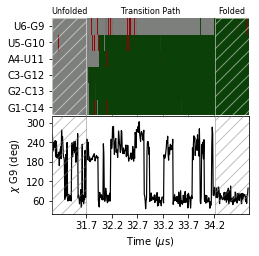

In [198]:
# loop over TPs and plot 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors  = ["#980002","#7d7f7c","#0b4008"]
mycm = ListedColormap(sns.color_palette(colors))
lst = [1]
for i in lst:
    
    oo = 75
    nidxs = range(tps[i][0]-oo,tps[i][-1]+oo)
    stem_tp = count_stem(pairings,nidxs)
    #fig, (ax1,ax2) = plt.subplots(2,1,figsize=(3.5,3.4),sharex=True)   
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(3.5,3.4),sharex=True)    
# plot heatmap

    g = sns.heatmap(stem_tp.T,cbar=False,ax=ax1,cmap=mycm,\
                yticklabels=["G1-C14","G2-C13","C3-G12","A4-U11","U5-G10","U6-G9"],\
                lw=0.0,alpha=0.9,rasterized=True,edgecolor=None)

    #set nice tick labels
    #g.set_yticklabels(g.get_yticklabels(),rotation=0)
    ax1.set_ylim(0,6.0)
    ax1.set_xticks([])


    # overlay value of chi in G9
    aa = np.copy(angles[nidxs,8,6])
    # plot in 0-2pi range
    aa[np.where(aa<0.0)] += 2.*np.pi
    # convert from rad to deg
    aa *= (180./np.pi)
    # plot
    ax2.plot(np.arange(len(nidxs)),aa,c='k',lw=1.2)
    
    # set limits
    ax2.set_ylim(20,320)
    ax2.set_ylabel(r"$\chi$ G9 (deg)")
    ax2.set_yticks([60,120,180,240,300])
    ll = np.linspace(0,2500,6)
    ll1 = (ll)/9. + oo
    ax2.set_xticks(ll1)
    ll2 = np.linspace(tps[i][0],tps[i][-1],6)
    print ll2
    ax2.set_xticklabels(["%3.1f" % (x*0.009) for x in ll2],rotation=0)
    ax2.set_xlabel("Time ($\mu$s)")
    
    # draw lines at the beginning and end of TP
    #ax1.axvline(oo,color='y',lw=2.5,zorder=10,ls="--")
    ax1.fill([0,0,oo,oo],[0,6,6,0],zorder=10,hatch="//",edgecolor='w',fc='none',alpha=0.5)
    ax2.fill([0,0,oo,oo],[0,360,360,0],zorder=10,hatch="//",edgecolor='0.5',fc='none',alpha=0.5)
    
    ax1.fill([oo+len(tps[i]),oo+len(tps[i]),2*oo+len(tps[i]),2*oo+len(tps[i])],\
             [0,6,6,0],zorder=10,hatch="//",edgecolor='w',fc='none',alpha=0.5)

    ax2.fill([oo+len(tps[i]),oo+len(tps[i]),2*oo+len(tps[i]),2*oo+len(tps[i])],\
             [0,360,360,0],zorder=10,hatch="//",edgecolor='0.5',fc='none',alpha=0.5)

    #ax1.axvline(len(tps[i]) + oo,color='y',ls="--",lw=2.5)
    #ax2.axvline(oo,color='y',lw=2.5,zorder=10,ls="--")
    #ax2.axvline(len(tps[i]) + oo,color='y',lw=2.5,ls="--")
    ax1.text(oo/2,6.25,"Unfolded",ha='center',fontsize=8)
    ax1.text(1.5*oo+len(tps[i]),6.25,"Folded",ha='center',fontsize=8)
    ax1.text(oo+0.5*(len(tps[i])),6.25,"Transition Path",ha='center',fontsize=8)
    fig.subplots_adjust(left=0.2, bottom=0.15, right=0.98, top=0.95, wspace=0.0, hspace=0.01)
    plt.show()
    
    #plt.savefig("figure_02a.png",dpi=600)
    #plt.close()


Finally, we quantify the order of the events in folding by calculating the two following quantities:
1. the fraction of formed WC-pairs ($q1$)
2. the normalized quantity $q2 = 0.5*(1+cos(\chi-1.104))$, that has a maximum $q2=1$ when $\chi=1.014 rad$.

We then average $q1,q2$ over the TP, so that quantities that reach a native-like value (i.e. 1) early during folding have a high value and those that form late get a low value. Here, we can see that the Watson-Crick base pairs form early in folding, while the transition of the $\chi$ angle to syn with the formation of the SWt base-pairs occurs later. 

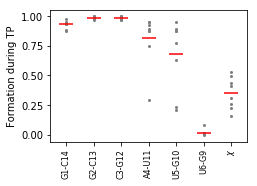

In [199]:
averages = []
averages2 = []
for i in range(len(tps)):
    
    # count the base-pair interaction in stem
    stem_tp = count_stem(pairings,tps[i])
    
    # calculate the fraction of formed WC pairs in stem
    q1 = np.sum(stem_tp[:,:-1],axis=1)/5.
    # calculate the cosine distance from the syn conformation
    q2 = 0.5*(1.+ np.cos(angles[tps[i],8,6]-1.104) )
    averages.append([np.average(q1), np.average(q2)])
    
    q3 = np.average(stem_tp[:,0]>0)
    q4 = np.average(stem_tp[:,1]>0)
    q5 = np.average(stem_tp[:,2]>0)
    q6 = np.average(stem_tp[:,3]>0)
    q7 = np.average(stem_tp[:,4]>0)
    q8 = np.average(stem_tp[:,5]>0)
    averages2.append([q3,q4,q5,q6,q7,q8,np.average(q2)])
    
    
averages = np.array(averages)
averages2 = np.array(averages2)
averages3 = np.average(np.array(averages2),axis=0)

fig, ax1 = plt.subplots(1,1,figsize=(3.5,2.5))   
for j in range(averages2.shape[1]):
    ax1.scatter([j]*averages2.shape[0],averages2[:,j],c='0.5',s=4,marker="o")
ax1.scatter(range(averages2.shape[1]),averages3,c='r',marker="_",s=200) 
#ax1.plot([0,1],[0,1],c='k')
#ax1.set_aspect(1.)
plt.xticks([0,1,2,3,4,5,6],["G1-C14","G2-C13","C3-G12","A4-U11","U5-G10","U6-G9",r"$\chi$"],\
           rotation=90, fontsize=8)
ax1.set_yticks([0,0.25,0.5,0.75,1.0])
plt.ylabel("Formation during TP")
#ax1.set_xlabel("q1 - Watson-Crick pairs",fontsize=10)
#ax1.set_ylabel(r"q2 - $\chi$ angle, G9",fontsize=10)

fig.subplots_adjust(left=0.2, bottom=0.25, right=0.98, top=0.98, wspace=0.1, hspace=0.1)
plt.show()
#plt.savefig("figure_02b.png",dpi=600)
#plt.close()
